<a href="https://colab.research.google.com/github/DrLennon666/DAT4-students/blob/master/pytorchlightning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pytorch Lightning Tutorial

In [0]:
# imports
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

To begin ths tutorial we will follow a standard Pytorch workflow.

1. Defining transforms
2. Getting train, validation, and test data.
3. Creating dataloaders.
4. Create the NN architecture
5. Standard Pytorch training loop.

In [0]:
transform_list = [transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]
transform = transforms.Compose(transform_list)

trainset = torchvision.datasets.MNIST('./data', 
              download=True, train=True, transform=transform)
testset = torchvision.datasets.MNIST('./data', 
              download=True, train=False, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [55000, 5000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, 
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                         shuffle=True, num_workers=2)

torch.Size([4, 1, 28, 28])
labels: tensor([6, 8, 2, 7])


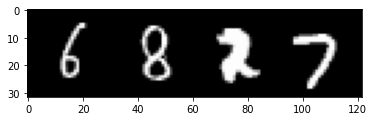

In [0]:
# inspect a batch of training data
images, labels = iter(valloader).next()
print(images.size())

# Unnormalize images
images = 0.5*images + 0.5
image_grid = torchvision.utils.make_grid(images).numpy()
# make channels last
image_grid = np.transpose(image_grid, (1,2,0))
plt.imshow(image_grid)
print('labels:', labels)

In [0]:
class fc_mnist(nn.Module):

  def __init__(self):
    super(fc_mnist, self).__init__()
    self.fc1 = nn.Linear(28*28, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x
net = fc_mnist()
print(net)

fc_mnist(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
# standard pytorch training loop

num_epochs = 5

for epoch in range(num_epochs):
  train_loss = []
  val_loss = []
  for i, data in enumerate(trainloader, 0):
    # Clear gradients
    optimizer.zero_grad()

    # get data, this is a list of [inputs, labels]
    inputs, labels = data # if using GPU data[0].to(device), data[1].to(device)

    # make predictions and calculate loss.
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    train_loss.append(loss.item())
    # backprop through loss
    loss.backward()
    # update gradients
    optimizer.step()
  with torch.no_grad():
    for i, data in enumerate(valloader, 0):
      inputs, labels = data
      outputs = net(inputs)
      val_loss.append(criterion(outputs, labels).item())
    val_loss = torch.mean(torch.tensor(val_loss))
    train_loss = torch.mean(torch.tensor(train_loss))
  print('Epoch: {}'.format(epoch))
  print('train loss: ', train_loss.item())
  print('validation loss: ', val_loss.item())
  

print('finished training')

Epoch: 0
train loss:  0.34027838706970215
validation loss:  0.1921464204788208
Epoch: 1
train loss:  0.1545868217945099
validation loss:  0.15143214166164398
Epoch: 2
train loss:  0.11228736490011215
validation loss:  0.10021787881851196
Epoch: 3
train loss:  0.09012088179588318
validation loss:  0.12162426859140396
Epoch: 4
train loss:  0.0727255716919899
validation loss:  0.10425873845815659
finished training


# [Pytorch Lightning](https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09)

In [0]:
!pip install pytorch_lightning

import pytorch_lightning as pl

In [0]:
class fc_mnist_lightning(pl.LightningModule):

  def __init__(self):
    super(fc_mnist_lightning, self).__init__()
    self.fc1 = nn.Linear(28*28, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x
  
  def cross_entropy_loss(self, logits, labels):
    criterion = nn.CrossEntropyLoss()
    return criterion(logits, labels)

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    logits = self.forward(x)
    loss = self.cross_entropy_loss(logits, y)

    logs ={'train_loss':loss}
    return {'loss': loss, 'log':logs}
  
  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    logits = self.forward(x)
    loss = self.cross_entropy_loss(logits, y)
    return {'val_loss':loss}

  def validation_epoch_end(self, outputs):
    # called at the end of the validation epoch
    # outputs is an array with what you returned in validation_step for each batch
    # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}]
    avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    tensorboard_logs = {'val_loss':avg_loss}
    return {'avg_val_loss': avg_loss, 'log':tensorboard_logs}

  def prepare_data(self):
    # transforms for images
    transform_list = [transforms.ToTensor(), transforms.Normalize(0.1307, 0.3081)]
    transform = transforms.Compose(transform_list)

    trainset = torchvision.datasets.MNIST('./data', 
              download=True, train=True, transform=transform)
    testset = torchvision.datasets.MNIST('./data', 
              download=True, train=False, transform=transform)

    self.trainset, self.valset = torch.utils.data.random_split(trainset, [55000, 5000])
    
  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.trainset, batch_size=64, shuffle=True, num_workers=2)

  def val_dataloader(self):
    return  torch.utils.data.DataLoader(self.valset, batch_size=64, shuffle=False, num_workers=2)

  #def test_dataloader(self):
  #  return  torch.utils.data.DataLoader(self.testset, batch_size=64, shuffle=True, num_workers=2)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    return optimizer


  

In [24]:
# train
model = fc_mnist_lightning()
trainer = pl.Trainer()

trainer.fit(model)

INFO:lightning:GPU available: False, used: False
INFO:lightning:
  | Name | Type   | Params
----------------------------
0 | fc1  | Linear | 100 K 
1 | fc2  | Linear | 33 K  
2 | fc3  | Linear | 2 K   
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Buffered data was truncated after reaching the output size limit.